In [116]:
# terminal에서 다음과 같이 설치하기
# pip install scikit-learn 
# pip install xgboost
# pip install lightgbm
# pip install scipy

In [117]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory


In [118]:
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard

import pandas as pd
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

house = pd.read_csv("C:/hkpark_/data-science-tutorial/data-science-tutorial/dataset/kc_house_data.csv")


In [119]:
house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.000,3,1.000,1180,5650,1.000,0,0,...,7,1180,0,1955,0,98178,47.511,-122.257,1340,5650
1,6414100192,20141209T000000,538000.000,3,2.250,2570,7242,2.000,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000.000,2,1.000,770,10000,1.000,0,0,...,6,770,0,1933,0,98028,47.738,-122.233,2720,8062
3,2487200875,20141209T000000,604000.000,4,3.000,1960,5000,1.000,0,0,...,7,1050,910,1965,0,98136,47.521,-122.393,1360,5000
4,1954400510,20150218T000000,510000.000,3,2.000,1680,8080,1.000,0,0,...,8,1680,0,1987,0,98074,47.617,-122.045,1800,7503


In [120]:
house.shape

(21613, 21)

In [121]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    house, 
    test_size = 0.10, 
    random_state = 20)

In [122]:
print(train.shape)
print(test.shape)

(19451, 21)
(2162, 21)


In [123]:
# knn_X = house_scale_0.drop("price", axis = 1)
# knn_y = house_scale_0["price"] # I want estimate to acceleration
house.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Outliers

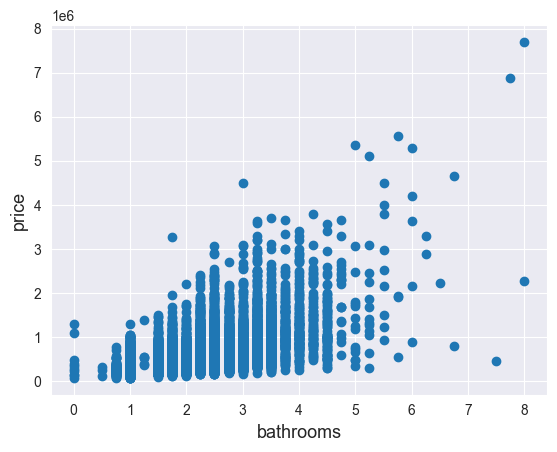

In [124]:
fig, ax = plt.subplots()
ax.scatter(x = train['bathrooms'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('bathrooms', fontsize=13)
plt.show()

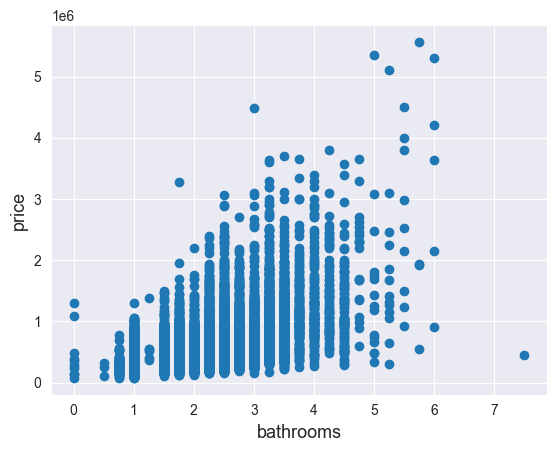

In [125]:
#Deleting outliers
train = train.drop(train[(train['bathrooms']>6) & (train['price']>600000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train['bathrooms'], y = train['price'])
plt.ylabel('price', fontsize=13)
plt.xlabel('bathrooms', fontsize=13)
plt.show()

Target Variable


 mu = 538539.53 and sigma = 355929.53



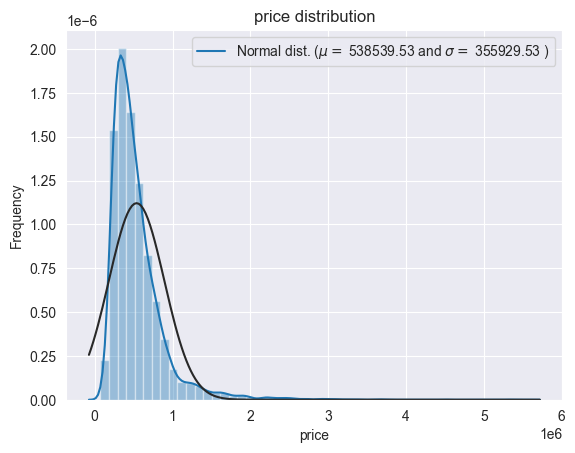

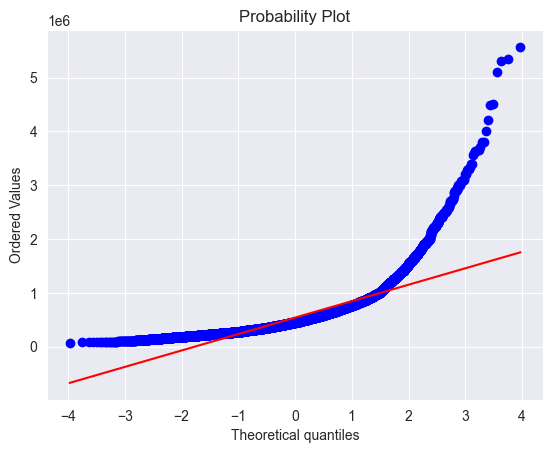

In [126]:
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('price distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

Log-transformation of the target variable


 mu = 13.05 and sigma = 0.52



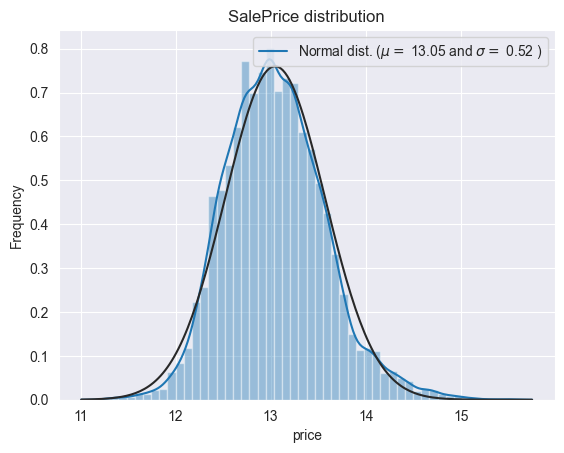

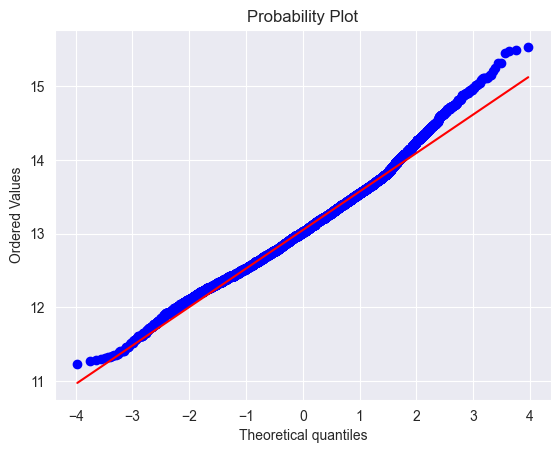

In [127]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["price"] = np.log1p(train["price"])

#Check the new distribution 
sns.distplot(train['price'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

In [128]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data=all_data.drop(["date","id"], axis = 1)

all_data.drop(['price'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (21605, 18)


Missing Data

In [129]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


Data Correlation

In [130]:
train=train.drop(["date","id"], axis = 1)

In [131]:
train.dtypes

price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

<Axes: >

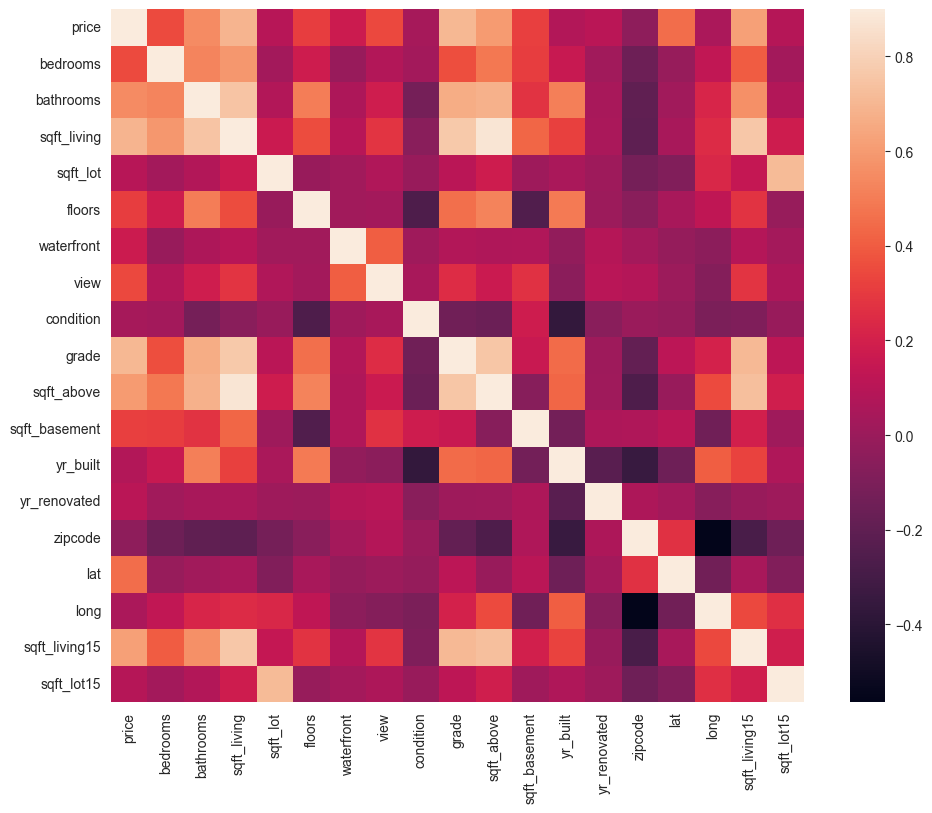

In [132]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

##More features engeneering

Transforming some numerical variables that are really categorical

In [133]:
#floors
all_data['view'] = all_data['view'].apply(str)


#Changing zipcode into a categorical variable
all_data['condition'] = all_data['condition'].astype(str)


#Yearare transformed into categorical features.
all_data['waterfront'] = all_data['waterfront'].astype(str)

In [134]:
from sklearn.preprocessing import LabelEncoder
cols = ('view', 'condition', 'waterfront')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (21605, 18)


In [135]:
# Adding total sqfootage feature 
all_data['Total_sqft'] = all_data['sqft_living'] + all_data['sqft_lot'] + all_data['sqft_above']+ all_data['sqft_basement'] + all_data['sqft_living15']+ all_data['sqft_lot15']  	

Skewed features

In [136]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(50)


Skew in numerical features: 



,Skew
sqft_lot,13.095
waterfront,11.418
Total_sqft,9.833
sqft_lot15,9.529
yr_renovated,4.557
view,3.401
bedrooms,1.976
sqft_basement,1.504
sqft_above,1.358
sqft_living,1.280


Box Cox Transformation of (highly) skewed features

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x

Note that setting  λ=0   is equivalent to log1p used above for the target variable.
참고 : 
https://onlinestatbook.com/2/transformations/box-cox.html
https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [137]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 19 skewed numerical features to Box Cox transform


Getting dummy categorical features

In [138]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(21605, 19)


In [139]:
all_data.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Total_sqft
0,0.730,0.730,10.869,13.016,0.730,0.000,0.000,1.194,2.440,10.869,0.000,14.093,0.000,30.716,5.272,NaN,12.370,13.046,17.316
1,1.541,1.378,12.675,12.583,1.541,0.000,0.000,1.194,2.440,12.675,0.000,14.189,0.000,30.717,5.275,NaN,12.778,12.708,17.966
2,2.056,1.541,15.155,19.109,0.730,0.000,1.194,1.194,2.603,14.039,11.507,14.109,0.000,30.721,5.272,NaN,14.275,17.531,23.021
3,1.541,1.378,14.720,27.637,1.541,0.000,0.000,1.541,2.603,14.720,0.000,14.155,0.000,30.714,5.271,NaN,15.007,26.196,31.055
4,1.541,0.730,11.981,18.465,0.730,0.000,0.000,1.541,2.440,11.981,0.000,14.104,0.000,30.717,5.275,NaN,13.118,18.598,22.188


In [140]:
train = all_data[:ntrain]
test = all_data[ntrain:]

Modelling

In [141]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [151]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

LASSO Regression :
This model may bme very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [143]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Elastic Net Regression :
again made robust to outliers

In [144]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression :

In [145]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [146]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

XGBoost :

In [147]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [148]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

models scores

Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [168]:
# score = rmsle_cv(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(ENet)
# print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(KRR)
# print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# score = rmsle_cv(GBoost)
# print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))




Xgboost score: 0.1680 (0.0031)

[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current v

In [ ]:
# Stacking models 할 차례, In[55] 차례